In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Данные

In [2]:
df = pd.read_csv('gazprom_data.csv', header=0, index_col=0)
df

,Revenue(mln rub),Natural Gas (usd/m3),usd/rub,eur/rub
1999,4.623440e+05,2.329,27,NaN
2000,5.848990e+05,9.775,28,NaN
2001,6.663913e+05,2.570,30,NaN
2002,7.258023e+05,4.789,32,NaN
2003,8.137387e+05,6.189,29,NaN
2004,1.060025e+06,6.149,28,NaN
2005,1.504144e+06,11.225,29,34.0
2006,1.986300e+06,5.740,26,35.0
2007,2.620281e+06,7.483,25,36.0
2008,2.899911e+06,5.622,29,41.0


# Построим простую модель выручки

In [3]:
df['Diff Revenue(mln rub)'] = df['Revenue(mln rub)'].diff()
data = df.loc[2005:]
train_test_split_index = 2014
data_train = data.loc[:train_test_split_index]
data_test = data.loc[train_test_split_index:].iloc[1:]

Text(0.5,1,'Diff Revenue(mln rub) predict')

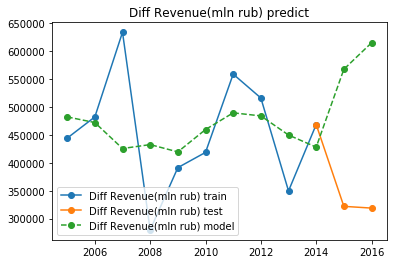

In [4]:
X_columns = ['Natural Gas (usd/m3)', 'usd/rub', 'eur/rub']
y_column = 'Diff Revenue(mln rub)'
model = LinearRegression()
model.fit(X=data_train[X_columns], y=data_train[y_column])
model_forecast = model.predict(X=data[X_columns])
model_forecast = pd.Series(index=data.index, name='{} model'.format(y_column), data=model_forecast)

# PLOT PREDICTIONS
fig, ax = plt.subplots()
data_train[y_column].plot(ax=ax, style='o-', label='{} train'.format(y_column))
data.loc[train_test_split_index:][y_column].plot(ax=ax, style='o-', label='{} test'.format(y_column))
model_forecast.plot(ax=ax, style='o--', label=model_forecast.name)
ax.legend()
ax.set_title('{} predict'.format(y_column))

(<matplotlib.legend.Legend at 0x27512f83cf8>,
 Text(0.5,1,'Revenue(mln rub) forecast'))

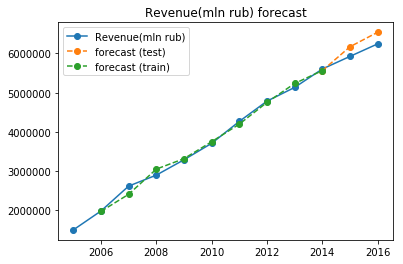

In [5]:
revenue_forecast = model_forecast.to_frame()
revenue_forecast['Revenue forecast'] = None
for i in revenue_forecast.index[1:]:
    revenue_forecast.at[i, 'Revenue forecast'] = data.loc[i-1]['Revenue(mln rub)'] + revenue_forecast.loc[i]['Diff Revenue(mln rub) model']
    
fig, ax = plt.subplots()
data['Revenue(mln rub)'].plot(ax=ax, style='o-')
revenue_forecast['Revenue forecast'].loc[train_test_split_index:].plot(ax=ax, style='o--', label='forecast (test)')
revenue_forecast['Revenue forecast'].loc[:train_test_split_index].plot(ax=ax, style='o--', label='forecast (train)')
ax.legend(), ax.set_title('Revenue(mln rub) forecast')

# Задание
1. Что не так с моделью выше? (опишите в двух-трех предложениях)
2. На имеющихся данных постройте модель выручки, устойчивую с точки зрения сценарного моделирования

# Решение

### 0. Анализ построенной модели

Посмотрим на коэффициенты модели

COEFFICIENTS
Natural Gas (usd/m3): -9356.009303415247
usd/rub: 15630.896943772315
eur/rub: -14585.42535752141
intercept: 629868.0423158079



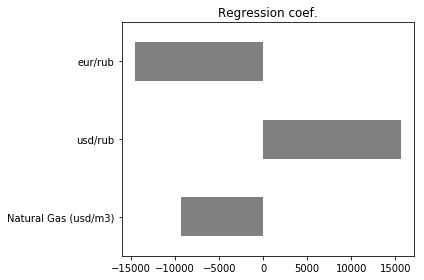

In [6]:
print('COEFFICIENTS')
for i, f in enumerate(data[X_columns].columns):
    print('{}: {}'.format(f, model.coef_[i]))
print('intercept: {}'.format(model.intercept_)), print()
coeffs = pd.Series(index=data[X_columns].columns, data=model.coef_)

fig, ax = plt.subplots()
coeffs.plot(ax=ax, kind='barh', color='grey', title='Regression coef.') 
fig.tight_layout()

Видим, что коэффициент при курсе евро отрицательный, а при курсе доллара положительный - это не логично, т.к. курсы этих валют ведут себя очень согласованно и, следовательно, должны иметь схожую зависимость с целевой переменной.

При сценарном моделировании может возникнуть противоречивая ситуация, когда при увеличении курса евро при неизменном курсе доллара выручка будет падать, а при увеличении курса доллара и неизменном курсе евро выручка будет расти.

### 1. Проверка коллинеарности с помощью матрицы корреляции

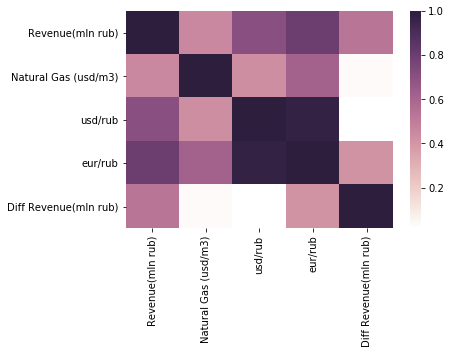

In [7]:
sns.heatmap(df.corr().abs(), cmap=sns.cubehelix_palette(light=1, as_cmap=True))

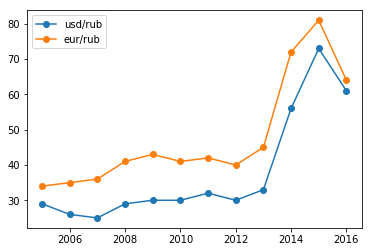

In [8]:
data[['usd/rub', 'eur/rub']].plot(style='o-')

Видно, что два курса валют сильно коррелируют между собой, что не позволяет их правильно включить в одну модель линейной регрессии. Поэтому создадим ансамбль из двух моделей, в каждой из которых будет по одному курсу валют.

### 2. Проверка мультиколлинеарности с помощью Variance Inflation Factor (VIF) 

$VIF_i = \frac{1}{1-R_i}$, где
$R_i$ - это коэффициент детерминации регрессии на целевую переменную $X_i$ от всех переменных $X$, кроме $i$-го (для $i=1$ это регрессия следующего вида $X_1=\alpha_0 + \alpha_2 X_2 + \alpha_3 X_3 + \cdots + \alpha_k X_k +e$). Перменная $y$ здесь никак не участвует.

Подробнее: https://en.wikipedia.org/wiki/Variance_inflation_factor

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = X_columns
vif["VIF Factor"] = [variance_inflation_factor(data[X_columns].values, i) for i in range(len(X_columns))]
vif

,features,VIF Factor
0,Natural Gas (usd/m3),3.112862
1,usd/rub,99.444103
2,eur/rub,112.424942


Значения больше 5-10 свидетельствуют о вероятном наличии мультиколлинеарности. Мы наблюдаем это снова у курсов валют, но не у природного газа.

### 3. Построение ансамбля моделей, в каждой из которых отсутствуют мультиколлинеарные факторы

COEFFICIENTS lr1
Natural Gas (usd/m3): -1210.3443986556672
usd/rub: -967.0723736231009
intercept: 491704.1179953862

COEFFICIENTS lr2
Natural Gas (usd/m3): -2912.8525572444055
eur/rub: -1369.960280191375
intercept: 528638.5382130019



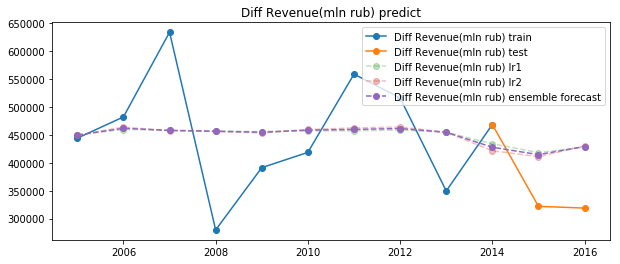

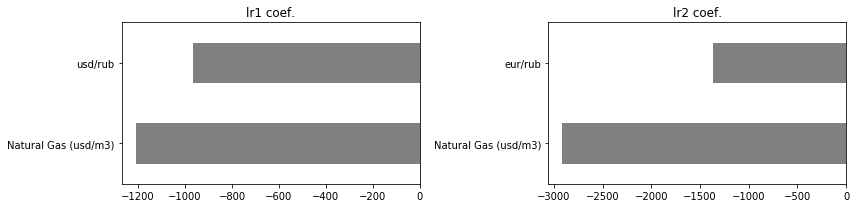

In [10]:
y_column = 'Diff Revenue(mln rub)'

X1_columns = ['Natural Gas (usd/m3)', 'usd/rub']
lr1 = LinearRegression()
lr1.fit(X=data_train[X1_columns], y=data_train[y_column])
lr1_forecast = pd.Series(index=data.index, name='{} lr1'.format(y_column), data=lr1.predict(X=data[X1_columns]))

X2_columns = ['Natural Gas (usd/m3)', 'eur/rub']
lr2 = LinearRegression()
lr2.fit(X=data_train[X2_columns], y=data_train[y_column])
lr2_forecast = pd.Series(index=data.index, name='{} lr2'.format(y_column), data=lr2.predict(X=data[X2_columns]))

model_forecast = ((lr1_forecast+lr2_forecast)/2).rename('{} ensemble forecast'.format(y_column))

# PLOT PREDICTIONS
fig, ax = plt.subplots(figsize=(10, 4))
data_train[y_column].plot(ax=ax, style='o-', label='{} train'.format(y_column))
data.loc[train_test_split_index:][y_column].plot(ax=ax, style='o-', label='{} test'.format(y_column))
lr1_forecast.plot(ax=ax, style='o--', alpha=0.3)
lr2_forecast.plot(ax=ax, style='o--', alpha=0.3)
model_forecast.plot(ax=ax, style='o--', label=model_forecast.name)
ax.legend()
ax.set_title('{} predict'.format(y_column))

# COEFFICIENTS
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
print('COEFFICIENTS lr1')
for i, f in enumerate(data[X1_columns].columns):
    print('{}: {}'.format(f, lr1.coef_[i]))
print('intercept: {}'.format(lr1.intercept_)), print()
coeffs = pd.Series(index=data[X1_columns].columns, data=lr1.coef_)
coeffs.plot(ax=ax[0], kind='barh', color='grey', title='lr1 coef.') 

print('COEFFICIENTS lr2')
for i, f in enumerate(data[X2_columns].columns):
    print('{}: {}'.format(f, lr2.coef_[i]))
print('intercept: {}'.format(lr2.intercept_)), print()
coeffs = pd.Series(index=data[X2_columns].columns, data=lr2.coef_)
coeffs.plot(ax=ax[1], kind='barh', color='grey', title='lr2 coef.') 

fig.tight_layout()

Теперь коэффициенты при обоих курсах валют схожи и одного знака - значит, они имеют схожее влияние на выручку, что отражает физический смысл.